# Tofts model

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
[to do add some background info here]

## Test data
The QIBA DRO data was used for testing of the Tofts model.

Version: QIBA_v11_Tofts from MR Modality Datasets/Dynamic Contrast Enhanced (DCE) MRI/DCE-MRI DRO Data and Code/DCE-MRI DRO Data (Daniel Barboriak) /QIBA_v11_Tofts/QIBA_v11_Tofts_GE/T1_tissue_500/DICOM_dyn

Test case labels: test_vox_T{parameter combination}_{SNR}, e.g. test_vox_T5_30

To get the high SNR dataset, data was averaged as follows:
- datVIF = data[:, :9, :]
- datVIF = np.mean(datVIF, axis=(0, 1))
- datT1 = np.mean(data[44:49, 13:18, :], (0, 1))
- datT2 = np.mean(data[32:37, 21:26, :], (0, 1))
- datT3 = np.mean(data[42:47, 23:28, :], (0, 1))
- datT4 = np.mean(data[22:27, 32:37, :], (0, 1))
- datT5 = np.mean(data[22:27, 43:48, :], (0, 1))

Noise was added to the high-SNR data to obtain data at different SNRs. SNR-levels of 20, 30, 50, and 100 were included.
A delayed version of the test data was created by shifting the time curves with 5 time points. This data is labeled as 'delayed' and only used with the models that allow the fitting of a delay.

The DRO data are signal values, which were converted to concentration curves using dce_to_r1eff from https://github.com/welcheb/pydcemri/blob/master from David S. Smith

Input values and reference values were found from the accompanying pdf document, which describes the values per voxel. 
- T1 blood of 1440
- T1 tissue of 500
- TR=5 ms
- FA=30
- Hct=0.45


Tolerances
- $v_e$: a_tol=0.05, r_tol=0, start=0.2, bounds=(0,1)
- $K^{trans}$: a_tol=0.005, r_tol=0.1, start=0.6, bounds=(0,5), units [/min]
- delay: a_tol=0.5, r_tol=0, start=0, bounds=(-10,10), units [s]


source: https://qibawiki.rsna.org/images/1/14/QIBA_DRO_2015_v1.42.pdf and https://qidw.rsna.org/#collection/594810551cac0a4ec8ffe574/folder/5e20ccb8b3467a6a9210e9ff

### Visualize test data
To get an impression of the test data that was used for the Tofts model, below we show the concentration time curves that were the input for the models.  
Here we show the data from high SNR from the original (first row) DRO and lowest SNR (SNR = 20; second row).

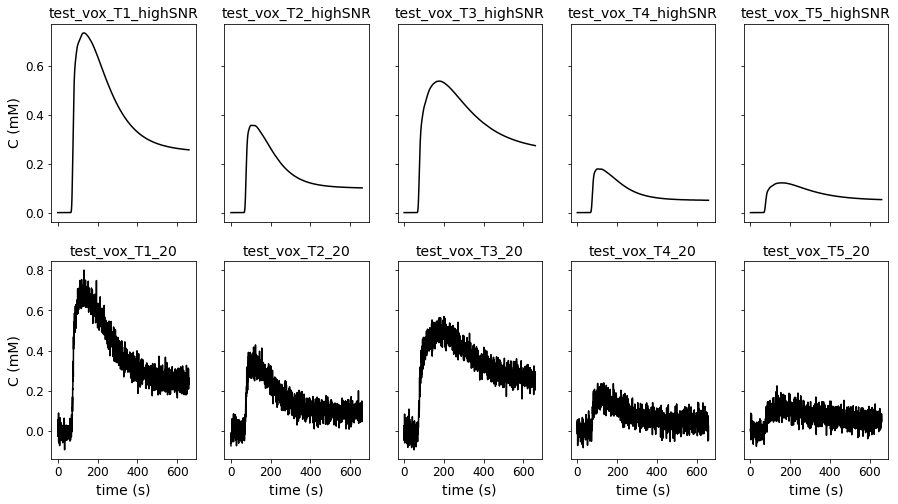

In [2]:
#plot test data. Load csv file of the test data.
filename = ('../test/DCEmodels/data/dce_DRO_data_tofts.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(15,8))
for currentvoxel in range(5):
    
    # first row is high SNR data
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_highSNR'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[0,currentvoxel].plot(t, c, color='black', label='highSNR')
    ax[0,currentvoxel].set_title(labelname, fontsize=14)
    if currentvoxel ==0:
        ax[0,currentvoxel].set_ylabel('C (mM)', fontsize=14)
    ax[0,currentvoxel].tick_params(axis='x', labelsize=12)
    ax[0,currentvoxel].tick_params(axis='y', labelsize=12)

    
    # second row is data with SNR of 20
    labelname = 'test_vox_T' + str(currentvoxel+1) + '_20'
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax[1,currentvoxel].set_title(labelname, fontsize=14)
    ax[1,currentvoxel].plot(t, c, color='black', label='SNR 20')
    ax[1,currentvoxel].set_xlabel('time (s)', fontsize=14)
    if currentvoxel ==0:
        ax[1,currentvoxel].set_ylabel('C (mM)', fontsize=14)
    ax[1,currentvoxel].tick_params(axis='x', labelsize=12)
    ax[1,currentvoxel].tick_params(axis='y', labelsize=12)
   
    

## Import data

Import the csv files with test results. The source data are labelled and the difference between measured and reference values was calculated.

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'tofts') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
# split delayed and non-delayed data
df['delay'] = df['label'].str.contains('_delayed')

# label data source
df['source']=''
df.loc[df['label'].str.contains('highSNR'),'source']='highSNR'
df.loc[df['label'].str.contains('_20'),'source']='SNR20'
df.loc[df['label'].str.contains('_30'),'source']='SNR30' 
df.loc[df['label'].str.contains('_50'),'source']='SNR50' 
df.loc[df['label'].str.contains('_100'),'source']='SNR100' 

author_list = df.author.unique()
no_authors = len(author_list)

# calculate error/difference between measured and reference values
df['error_Ktrans'] = df['Ktrans_meas'] - df['Ktrans_ref']
df['error_ve'] = df['ve_meas']- df['ve_ref']

# tolerances
tolerances = { 'Ktrans': {'atol' : 0.005, 'rtol': 0.1 },'ve': {'atol':0.05, 'rtol':0}, 'delay': {'atol' : 0.5, 'rtol': 0 }}

## Results

### Non-delayed results

Some models allow the fit of a delay. For the tests with non-delayed data, the delay was fixed to 0. 

The data of all test voxels are combined (low and high SNR)

Note that, one author (OGJ_OsloU_Norway) provided two options to fit the model (LLSQ and NLLS). These were considered separate contributions.

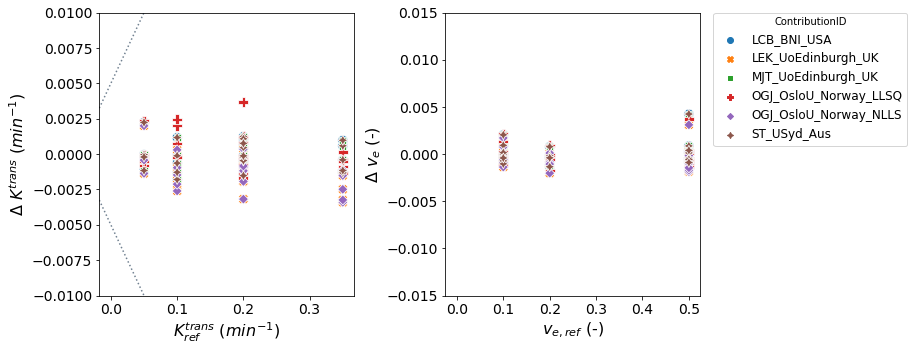

In [6]:
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,5))
plot_bland_altman(ax[0], df[~df['delay']], tolerances, 'Ktrans', ylim=(-0.01,0.01),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[~df['delay']], tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


Bias results estimated $K^{trans}$ values combined for all voxels and all SNR levels

In [7]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_Ktrans',grouptag='author')
print(resultsBA)

                           bias     stdev  LoA lower  LoA upper
author                                                         
LCB_BNI_USA           -0.000112  0.000994  -0.002061   0.001837
LEK_UoEdinburgh_UK    -0.001222  0.001230  -0.003632   0.001188
MJT_UoEdinburgh_UK    -0.000114  0.000993  -0.002060   0.001833
OGJ_OsloU_Norway_LLSQ  0.000145  0.001305  -0.002412   0.002702
OGJ_OsloU_Norway_NLLS -0.001222  0.001230  -0.003632   0.001188
ST_USyd_Aus           -0.000110  0.000994  -0.002059   0.001839


Split results in SNR level (only for high SNR data set and SNR of 20). The bias is slightly larger for the SNR of 20, compared to high SNR data.

In [8]:
# split in SNR level (only for high SNR data set and SNR of 20)
subset = df[(df['source']=='highSNR') & ~df['delay']]
resultsBA = bland_altman_statistics(data=subset,par='error_Ktrans',grouptag='author')
print('Bias results estimated Ktrans values for high SNR voxels')
print(resultsBA)

subset = df[(df['source']=='SNR20') & ~df['delay']]
resultsBA = bland_altman_statistics(data=subset,par='error_Ktrans',grouptag='author')
print('Bias results estimated Ktrans values for low SNR voxels (SNR = 20)')
print(resultsBA)

Bias results estimated Ktrans values for high SNR voxels
                           bias     stdev  LoA lower  LoA upper
author                                                         
LCB_BNI_USA           -0.000215  0.000134  -0.000478   0.000049
LEK_UoEdinburgh_UK    -0.001322  0.000880  -0.003046   0.000402
MJT_UoEdinburgh_UK    -0.000215  0.000134  -0.000478   0.000049
OGJ_OsloU_Norway_LLSQ -0.000218  0.000135  -0.000481   0.000046
OGJ_OsloU_Norway_NLLS -0.001322  0.000880  -0.003046   0.000402
ST_USyd_Aus           -0.000213  0.000133  -0.000474   0.000049
Bias results estimated Ktrans values for low SNR voxels (SNR = 20)
                           bias     stdev  LoA lower  LoA upper
author                                                         
LCB_BNI_USA            0.000357  0.001558  -0.002697   0.003412
LEK_UoEdinburgh_UK    -0.000755  0.001726  -0.004138   0.002628
MJT_UoEdinburgh_UK     0.000343  0.001559  -0.002713   0.003398
OGJ_OsloU_Norway_LLSQ  0.001088  0.002278  -

Bias results estimated $v_e$ values combined for all voxels and all SNR levels

In [9]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_ve',grouptag='author')
print(resultsBA)

                           bias     stdev  LoA lower  LoA upper
author                                                         
LCB_BNI_USA            0.000052  0.001132  -0.002166   0.002270
LEK_UoEdinburgh_UK    -0.000518  0.001130  -0.002733   0.001697
MJT_UoEdinburgh_UK     0.000052  0.001130  -0.002164   0.002267
OGJ_OsloU_Norway_LLSQ -0.000014  0.001126  -0.002221   0.002193
OGJ_OsloU_Norway_NLLS -0.000518  0.001130  -0.002733   0.001697
ST_USyd_Aus            0.000052  0.001132  -0.002166   0.002271


### Delayed results

Some contributions allowed the fitting of a delay. For those, additional tests with a delay were performed.

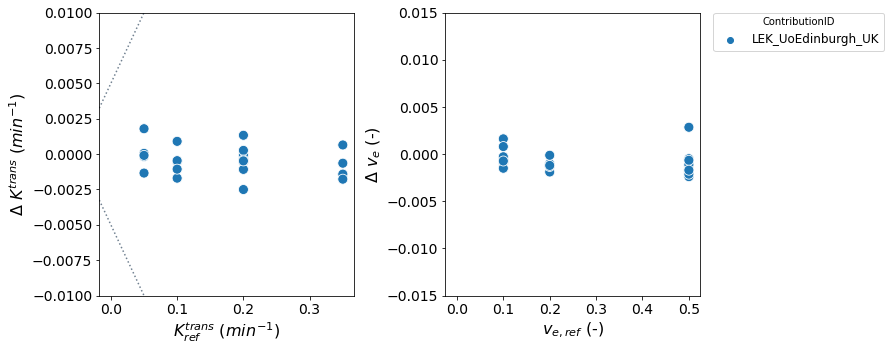

In [10]:
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,5))
plot_bland_altman(ax[0], df[df['delay']], tolerances, 'Ktrans', ylim=(-0.01,0.01),label_xaxis='$K^{trans}_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $K^{trans}$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[df['delay']], tolerances, 've', ylim=(-0.015,0.015),label_xaxis='$v_{e,ref}$ (-)',label_yaxis='$\Delta$ $v_{e}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


In [11]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_Ktrans',grouptag='author')
print(resultsBA)

                        bias     stdev  LoA lower  LoA upper
author                                                      
LEK_UoEdinburgh_UK -0.000482  0.000996  -0.002434   0.001469


In [12]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_ve',grouptag='author')
print(resultsBA)

                       bias     stdev  LoA lower  LoA upper
author                                                     
LEK_UoEdinburgh_UK -0.00077  0.001162  -0.003047   0.001507


## Notes

Some contributions included only the forward model, no fitting routine. For those cases we used the curvefit module from scipy package to estimate the output parameters. In all other cases the contributed fitting routine was included.

### References